# Henry Gu - Advanced Machine Learning Assignment 1 - Deep Neural Network / Determining Hyperparameters

Submitted the best scording model of the class with a Scoring Set MSE = 0.0034289926

### Setup

In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
# Code Removed for Privacy
# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
# Code Removed for Privacy

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Initial Data Checking

In [4]:
example_id = 1
def display_image(id, dataset):
    # Let's select a clean image from the dataset
    if dataset == 'clean':
        image_pixels = train_clean_X.iloc[example_id]
    elif dataset == 'noisy':
        image_pixels = train_noisy_X.iloc[example_id]

    # In order to plot an image, you need to reshape
    # the flattened array back into a 28x28 grid.
    image_pixels = image_pixels.values.reshape(28, 28)

    plt.imshow(image_pixels, cmap='binary')

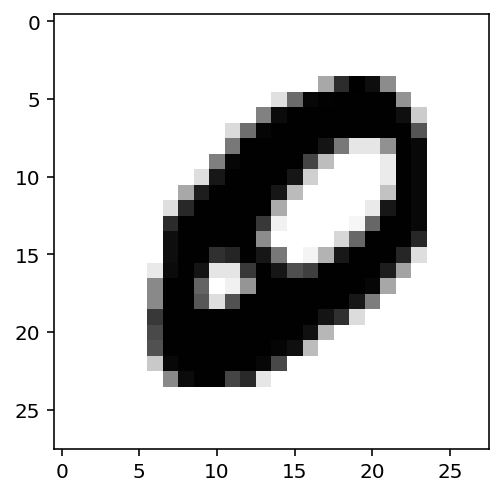

In [5]:
display_image(example_id, 'clean')

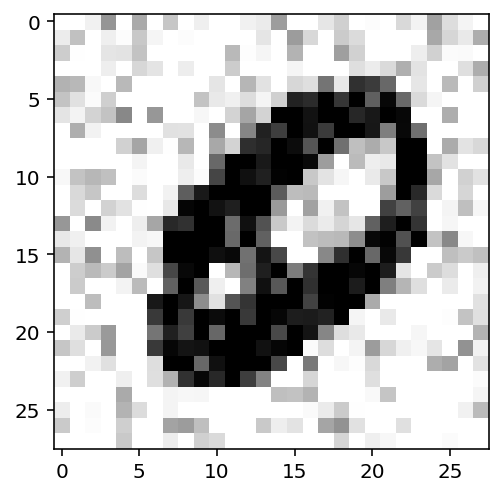

In [6]:
display_image(example_id, 'noisy')

In [7]:
train_y.iloc[example_id]

digit    0
Name: 1, dtype: uint8

In [8]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

def train_model(model, epochs):
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X),
        callbacks=[es]
    )
    return history

## Initial Models (run without seed)

Model 00b

In [9]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_00a(hp: HyperParameters):
    
    layers = [
        # Undercomplete Autooencoder
        Dense(
            units=hp.Int('encoder_width', min_value=5, max_value=784, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-5, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [10]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_00a = RandomSearch(
    build_model_00a,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_00a'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_00a.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_00a/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_00a/tuner0.json
Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 784, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


2021-10-03 21:39:43.247112: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-03 21:39:43.247207: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-03 21:39:43.247233: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ucla-jupyter): /proc/driver/nvidia/version does not exist
2021-10-03 21:39:43.247616: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-10-03 21:39:43.258419: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1497600000 Hz
2021-10-03 21:39:43.261035: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555b7a67bf00 initialized for platform Host (

In [11]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

tuner_00a.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [12]:
# The following function can be used to view the search summary.
tuner_00a.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_00a
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 299
learning_rate: 0.0012927360143612642
Score: 0.005438126623630524
Trial summary
Hyperparameters:
encoder_width: 766
learning_rate: 0.00013382300113227907
Score: 0.012148072322209677
Trial summary
Hyperparameters:
encoder_width: 708
learning_rate: 0.0001117904995493143
Score: 0.01469348929822445
Trial summary
Hyperparameters:
encoder_width: 83
learning_rate: 2.416596369450331e-05
Score: 0.07008355855941772
Trial summary
Hyperparameters:
encoder_width: 511
learning_rate: 0.2474453389311384
Score: 0.1163331816593806
Trial summary
Hyperparameters:
encoder_width: 649
learning_rate: 0.9796197242129118
Score: 0.11746202160914739
Trial summary
Hyperparameters:
encoder_width: 475
learning_rate: 0.8163668738420164
Score: 0.11747920513153076
Trial summary
Hyperparameters:
encoder_width: 638
learning_rate: 0.4960445261935281

In [13]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_00a.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
b8a2fda51667487cb6937e1a73bbbdbb,0.005438,299,0.001293
94f9c534694db5070396737e5a8a67f6,0.012148,766,0.000134
6cbdb2c8b928022a0af62d42dcc72f74,0.014693,708,0.000112
91db4608ff953bc191f1da58ffb52a32,0.070084,83,0.000024
bde6d68e7e595a141eeb8625602dcce9,0.116333,511,0.247445
b40bfdce3179372277c3731f46d80928,0.117462,649,0.979620
e76bf0e999ef8744fd701c9391bf8e3d,0.117479,475,0.816367
5374f0a075e07c8be1666ea70af2cc3b,0.119079,638,0.496045
9228aaa3b7f08986d00065abd889cd5b,0.123574,133,0.118716


In [14]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_00a.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_00a = build_model_00a(best_hyperparameters)
history = train_model(autoencoder_00a, epochs=20)

Epoch 1/20
383/383 [==============================] - 4s 11ms/step - loss: 0.0285 - val_loss: 0.0113
Epoch 2/20
383/383 [==============================] - 4s 9ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 3/20
383/383 [==============================] - 3s 9ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 4/20
383/383 [==============================] - 3s 9ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/20
383/383 [==============================] - 4s 10ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/20
383/383 [==============================] - 4s 9ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 7/20
383/383 [==============================] - 3s 9ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 8/20
383/383 [==============================] - 4s 9ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 9/20
383/383 [==============================] - 4s 9ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/20
383/383 [==============================] - 3s 9ms/step - loss: 0.0037 - val_loss: 0.00

In [15]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_00a.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

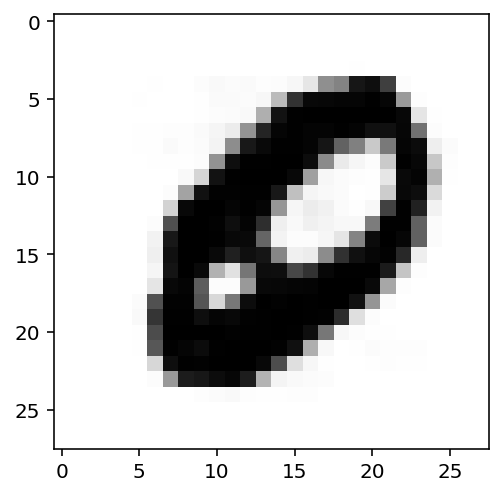

In [16]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [17]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.003355044

In [18]:
# Validation MSE
val_denoised_X = autoencoder_00a.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.003732987

In [19]:
# Test MSE
test_denoised_X = autoencoder_00a.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.003752441

Model 00b

In [20]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_00b(hp: HyperParameters):

    
    layers = [
        # Undercomplete or Overcomplete Autooencoder
        Dense(
            units=hp.Int('encoder_width', min_value=10, max_value=1500, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-6, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [21]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_00b = RandomSearch(
    build_model_00b,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_00b'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_00b.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_00b/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_00b/tuner0.json
Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1500, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [22]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner_00b.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [23]:
# The following function can be used to view the search summary.
tuner_00b.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_00b
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 1281
learning_rate: 0.0004036750136767237
Score: 0.003925766951094071
Trial summary
Hyperparameters:
encoder_width: 822
learning_rate: 0.004373799070130397
Score: 0.0041850182848672075
Trial summary
Hyperparameters:
encoder_width: 1431
learning_rate: 0.00019555934062090788
Score: 0.00483746025711298
Trial summary
Hyperparameters:
encoder_width: 98
learning_rate: 0.0038828410618021976
Score: 0.00685749916980664
Trial summary
Hyperparameters:
encoder_width: 1279
learning_rate: 8.360408590430646e-05
Score: 0.008471177580455938
Trial summary
Hyperparameters:
encoder_width: 561
learning_rate: 0.00014790837296402092
Score: 0.008693287459512552
Trial summary
Hyperparameters:
encoder_width: 363
learning_rate: 0.0001698191091110832
Score: 0.0102882186571757
Trial summary
Hyperparameters:
encoder_width: 887
learning_rate: 2.6

In [24]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_00b.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
d2d275607461c227343e1a82f5e05e27,0.003926,1281,0.000404
12d6a1a8c4f06a7679cad1746adae8c7,0.004185,822,0.004374
d72f4e0ebc8ee20f11836f1a1027c485,0.004837,1431,0.000196
c40ac68833895e99d7e43b5913deb713,0.006857,98,0.003883
f63e7f8eb7838cfe47239b97820c670e,0.008471,1279,0.000084
70f0871cc9663dd820493529b7e7ad79,0.008693,561,0.000148
8869afe8db2ae54c4fe2d686834ad531,0.010288,363,0.000170
587a3f90c09cec1f324c6c8bc4968fae,0.026523,887,0.000027
b21563ceaab987553988f01e03cd5e3a,0.029119,674,0.000028


In [25]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_00b.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_00b = build_model_00b(best_hyperparameters)
history = train_model(autoencoder_00b, epochs=20)

Epoch 1/20
383/383 [==============================] - 8s 20ms/step - loss: 0.0283 - val_loss: 0.0106
Epoch 2/20
383/383 [==============================] - 7s 19ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 3/20
383/383 [==============================] - 8s 22ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 4/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/20
383/383 [==============================] - 7s 17ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/20
383/383 [==============================] - 7s 19ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/20
383/383 [==============================] - 7s 19ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 10/20
383/383 [==============================] - 7s 19ms/step - loss: 0.0033 - val_lo

In [26]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_00b.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

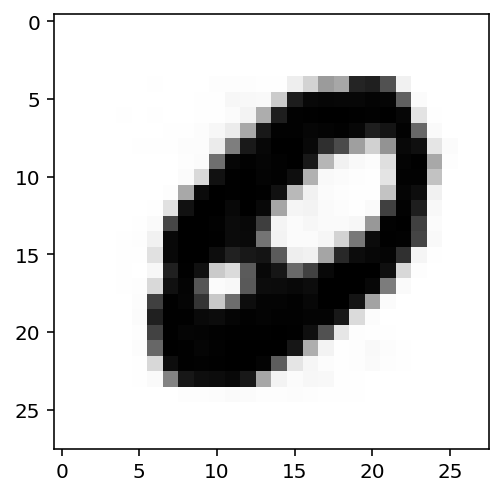

In [27]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [28]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0030786735

In [29]:
# Validate MSE
val_denoised_X = autoencoder_00b.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.0034148968

In [30]:
# Test MSE
test_denoised_X = autoencoder_00b.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.0034350972

## Model 1

In [31]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_1(hp: HyperParameters):
    
    layers = [
        # Undercomplete Autooencoder
        Dense(
            units=hp.Int('encoder_width', min_value=5, max_value=784, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-5, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [32]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_1 = RandomSearch(
    build_model_1,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    seed = 11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_01'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_1.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_01/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_01/tuner0.json
Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 784, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [33]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner_1.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [34]:
# The following function can be used to view the search summary.
tuner_1.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_01
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 757
learning_rate: 0.0006421165661811643
Score: 0.003997755392144124
Trial summary
Hyperparameters:
encoder_width: 357
learning_rate: 0.0023596815314090077
Score: 0.004063034585366647
Trial summary
Hyperparameters:
encoder_width: 432
learning_rate: 0.0049591566044750336
Score: 0.004215344941864411
Trial summary
Hyperparameters:
encoder_width: 412
learning_rate: 8.059800956363889e-05
Score: 0.016945260887344677
Trial summary
Hyperparameters:
encoder_width: 510
learning_rate: 3.671012394996135e-05
Score: 0.02780314286549886
Trial summary
Hyperparameters:
encoder_width: 207
learning_rate: 3.42091819151074e-05
Score: 0.04525237282117208
Trial summary
Hyperparameters:
encoder_width: 532
learning_rate: 0.3374414129312114
Score: 0.11660376191139221
Trial summary
Hyperparameters:
encoder_width: 133
learning_rate: 0.618083142

In [35]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_1.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
5212e673b24faa44db71f2363288a45c,0.003998,757,0.000642
3d9c387c94ba04cc312245b1cb12cdc3,0.004063,357,0.002360
228b6d46aa6e27b59652c46a681056bf,0.004215,432,0.004959
5eb2b201b99d2a93dd04920a4b47b8e3,0.016945,412,0.000081
c0100dac06d2c74fa5d44196f141025c,0.027803,510,0.000037
337ec84988321ad0041b439b9e79d33b,0.045252,207,0.000034
a5b626c66811b8dff92c3b7bfcc907ac,0.116604,532,0.337441
05aba5a005c166f158c24f7305ebe31e,0.118596,133,0.618083
ba2c0dd3e7cc6778c31e163eed4fb44c,0.130276,299,0.054508


In [36]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_1.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_1 = build_model_1(best_hyperparameters)
history = train_model(autoencoder_1, epochs=20)

Epoch 1/20
383/383 [==============================] - 7s 17ms/step - loss: 0.0272 - val_loss: 0.0102
Epoch 2/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 3/20
383/383 [==============================] - 7s 17ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 4/20
383/383 [==============================] - 7s 18ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/20
383/383 [==============================] - 6s 17ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 7/20
383/383 [==============================] - 6s 17ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/20
383/383 [==============================] - 7s 17ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 9/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0033 - val_lo

In [37]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_1.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

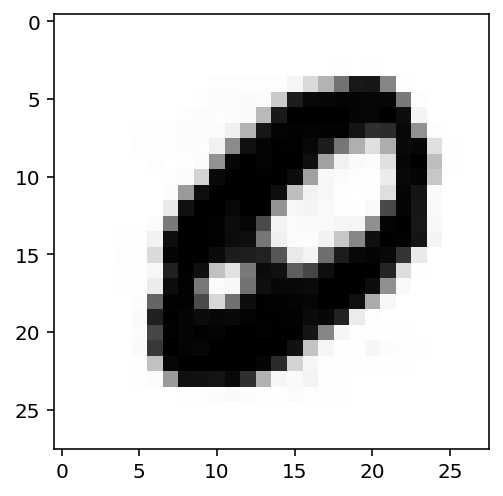

In [38]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [39]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0030897968

In [40]:
# Validate MSE
val_denoised_X = autoencoder_1.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.003476523

In [41]:
# Test MSE
test_denoised_X = autoencoder_1.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.0035004327

## Model 2

In [42]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_2(hp: HyperParameters):
    
    layers = [
        # Under or Overcomplete Autooencoder
        Dense(
            units=hp.Int('encoder_width', min_value=10, max_value=1500, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-6, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [43]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_2 = RandomSearch(
    build_model_2,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    seed = 11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_02'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_2.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_02/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_02/tuner0.json
Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1500, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [44]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner_2.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [45]:
# The following function can be used to view the search summary.
tuner_2.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_02
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 860
learning_rate: 0.0014914623602938733
Score: 0.003689116875951489
Trial summary
Hyperparameters:
encoder_width: 827
learning_rate: 0.0017158897803426344
Score: 0.0037214018714924655
Trial summary
Hyperparameters:
encoder_width: 534
learning_rate: 0.0019451225580466702
Score: 0.0038582947260389724
Trial summary
Hyperparameters:
encoder_width: 684
learning_rate: 0.0007037591786967162
Score: 0.003998099050174157
Trial summary
Hyperparameters:
encoder_width: 673
learning_rate: 0.0007193654464866931
Score: 0.004008726216852665
Trial summary
Hyperparameters:
encoder_width: 578
learning_rate: 0.006863739474770759
Score: 0.004700471802304189
Trial summary
Hyperparameters:
encoder_width: 1448
learning_rate: 0.00014761709330638468
Score: 0.0055564469657838345
Trial summary
Hyperparameters:
encoder_width: 323
learning_rate: 

In [46]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_2.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
84ae1408664e4eab5d68594dd43f994a,0.003689,860,0.001491
8c21ffa0d0bc2d9ad8f2f41c49d058e3,0.003721,827,0.001716
949a479166f01b660850150b6f8599b3,0.003858,534,0.001945
54aa90b4eb3d08aa0bb11ab7307164dd,0.003998,684,0.000704
ceae435491bf7db7ecce91167836a967,0.004009,673,0.000719
c0fff578c0ae6af1c139b12e8a9d8a76,0.004700,578,0.006864
598c2a032b8194e7048292d3ae59e38b,0.005556,1448,0.000148
d5d6a756f8e69301771ccccfffb83902,0.005559,323,0.000564
24e8e677735669947fba30ecaaff0cc2,0.007745,110,0.000967


In [47]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_2.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_2 = build_model_2(best_hyperparameters)
history = train_model(autoencoder_2, epochs=20)

Epoch 1/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0208 - val_loss: 0.0071
Epoch 2/20
383/383 [==============================] - 5s 14ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 3/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 5/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/20
383/383 [==============================] - 5s 14ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/20
383/383 [==============================] - 5s 14ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 00007: early stopping


In [48]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_2.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

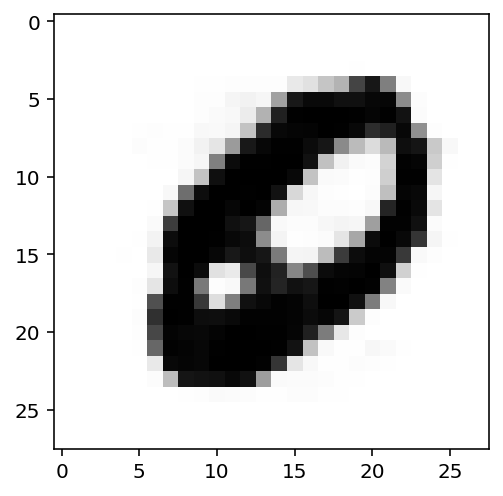

In [49]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [50]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0032684125

In [51]:
# Validate MSE
val_denoised_X = autoencoder_2.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.0036617431

In [52]:
# Test MSE
test_denoised_X = autoencoder_2.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.003686001

## Model 3

In [53]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_3(hp: HyperParameters):
    
    layers = [
        # Single Layer under or over complete autoencoder
        Dense(
            units=hp.Int('encoder_width', min_value=5, max_value=1500, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-6, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [54]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_3 = RandomSearch(
    build_model_3,
    objective='val_loss',
    max_trials=75,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    seed = 11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_03'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_3.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_03/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_03/tuner0.json
Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 1500, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [55]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner_3.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [56]:
# The following function can be used to view the search summary.
tuner_3.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_03
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 1390
learning_rate: 0.0012292146399012808
Score: 0.0036147932211558023
Trial summary
Hyperparameters:
encoder_width: 1242
learning_rate: 0.0007717556265736999
Score: 0.0036307493379960456
Trial summary
Hyperparameters:
encoder_width: 881
learning_rate: 0.0013142187269092555
Score: 0.0036738761700689793
Trial summary
Hyperparameters:
encoder_width: 858
learning_rate: 0.0014914623602938733
Score: 0.0036921092929939428
Trial summary
Hyperparameters:
encoder_width: 1369
learning_rate: 0.0019090149136833528
Score: 0.0037059750563154616
Trial summary
Hyperparameters:
encoder_width: 824
learning_rate: 0.0017158897803426344
Score: 0.003725914672637979
Trial summary
Hyperparameters:
encoder_width: 1360
learning_rate: 0.0004893316763889607
Score: 0.0037536276504397392
Trial summary
Hyperparameters:
encoder_width: 873
learning_

In [57]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_3.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
97c0d40a00bc20f5a5271f76895e0fa8,0.003615,1390,0.001229
ffd84a014785a836d8f8e22cd6ed6f57,0.003631,1242,0.000772
b6999be9aec0d806b1eccbbe46cb2ecf,0.003674,881,0.001314
0a31ead5523e0a6ff397e5f974705611,0.003692,858,0.001491
5a49069cd5fb14e5950b69c5f35dd889,0.003706,1369,0.001909
1ce478a38f11db9dd68657449750d71f,0.003726,824,0.001716
74ae55681e29e78bdd2d5aa59f550cc9,0.003754,1360,0.000489
67448a42b4b33a4c24d1d2d12434ff4f,0.003755,873,0.000845
5915dd3c6d6e702df6d309f624eb4799,0.003851,531,0.001945


In [58]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_3.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_3 = build_model_3(best_hyperparameters)
history = train_model(autoencoder_3, epochs=500)

Epoch 1/500
383/383 [==============================] - 8s 21ms/step - loss: 0.0199 - val_loss: 0.0067
Epoch 2/500
383/383 [==============================] - 7s 18ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 3/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/500
383/383 [==============================] - 7s 18ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 6/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 7/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 00007: early stopping


In [59]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_3.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

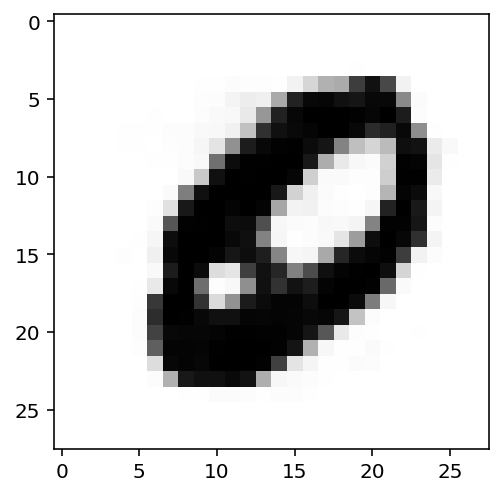

In [60]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [61]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0031836

In [62]:
# Validate MSE
val_denoised_X = autoencoder_3.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.003606023

In [63]:
# Test MSE
test_denoised_X = autoencoder_3.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.0036322544

## Model 4

In [64]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_4(hp: HyperParameters):
    
    layers = [
        # 2 layers Autooencoder
        Dense(
            units=hp.Int('encoder_width_1', min_value=5, max_value=1500, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),
        
        Dense(
            units=hp.Int('encoder_width_2', min_value=5, max_value=1500, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-6, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [65]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_4 = RandomSearch(
    build_model_4,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    seed = 11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_04'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_4.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_04/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_04/tuner0.json
Search space summary
Default search space size: 3
encoder_width_1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 1500, 'step': 1, 'sampling': 'linear'}
encoder_width_2 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 1500, 'step': 1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [66]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner_4.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [67]:
# The following function can be used to view the search summary.
tuner_4.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_04
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width_1: 1402
encoder_width_2: 1242
learning_rate: 0.0007717556265736999
Score: 0.003820758235330383
Trial summary
Hyperparameters:
encoder_width_1: 1410
encoder_width_2: 881
learning_rate: 0.0013142187269092555
Score: 0.003984404106934865
Trial summary
Hyperparameters:
encoder_width_1: 1392
encoder_width_2: 670
learning_rate: 0.0007193654464866931
Score: 0.004074728737274806
Trial summary
Hyperparameters:
encoder_width_1: 634
encoder_width_2: 1369
learning_rate: 0.0019090149136833528
Score: 0.004111925916125377
Trial summary
Hyperparameters:
encoder_width_1: 477
encoder_width_2: 622
learning_rate: 0.000918323932517095
Score: 0.004378519952297211
Trial summary
Hyperparameters:
encoder_width_1: 729
encoder_width_2: 1006
learning_rate: 0.002846408638804213
Score: 0.004428541908661525
Trial summary
Hyperparameters:
encoder_wid

In [68]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_4.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width_1,encoder_width_2,learning_rate
trial_id,,,,
2aef6fde8f0ee0b66205e726c12e8d9d,0.003821,1402,1242,0.000772
a5e62e21ddcdc897e997b195df33d537,0.003984,1410,881,0.001314
d9b63e9dc59f29ab65bd28e756a949a4,0.004075,1392,670,0.000719
51d9af3c1aa5258251e0119535acbb74,0.004112,634,1369,0.001909
cd46fbc41e5df9c53d20f40967d06652,0.004379,477,622,0.000918
5a5bf0902842462eb2caff94b412ea96,0.004429,729,1006,0.002846
c4a242693e479278c291958dffab8274,0.004654,1388,1070,0.000183
c7785488ca75ceec0357bb9a6d1fe429,0.004699,1159,778,0.003130
29755ab0c7467caa911a801917cee128,0.004866,340,465,0.000927


In [69]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_4.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_4 = build_model_4(best_hyperparameters)
history = train_model(autoencoder_4, epochs=200)

Epoch 1/200
383/383 [==============================] - 13s 34ms/step - loss: 0.0185 - val_loss: 0.0065
Epoch 2/200
383/383 [==============================] - 13s 33ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 3/200
383/383 [==============================] - 13s 33ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 4/200
383/383 [==============================] - 13s 33ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/200
383/383 [==============================] - 13s 33ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 6/200
383/383 [==============================] - 14s 38ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 7/200
383/383 [==============================] - 14s 37ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/200
383/383 [==============================] - 14s 38ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 9/200
383/383 [==============================] - 15s 39ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 10/200
383/383 [==============================] - 14s 37ms/step - l

In [70]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_4.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

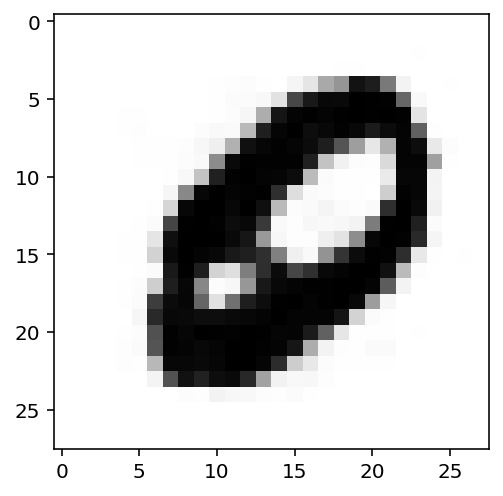

In [71]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [72]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.003047791

In [73]:
# Validate MSE
val_denoised_X = autoencoder_4.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.0036865529

In [74]:
# Test MSE
test_denoised_X = autoencoder_4.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.003702869

## Model 5

In [75]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_5(hp: HyperParameters):

    layers = [
        # Sparse Autooencoder
        Dense(
            units=hp.Int('encoder_width', min_value=5, max_value=784, sampling='linear'), 
            activation='elu', 
            input_shape=(28 * 28,),
            activity_regularizer=regularizers.l1(hp.Float(name='regularization_rate', min_value=1e-10, max_value=1e0, sampling='log'))
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-6, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [76]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_5 = RandomSearch(
    build_model_5,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    seed = 11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_05'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_5.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_05/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_05/tuner0.json
Search space summary
Default search space size: 3
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 784, 'step': 1, 'sampling': 'linear'}
regularization_rate (Float)
{'default': 1e-10, 'conditions': [], 'min_value': 1e-10, 'max_value': 1.0, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [77]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

tuner_5.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [78]:
# The following function can be used to view the search summary.
tuner_5.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_05
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_width: 757
regularization_rate: 2.664754079980125e-10
learning_rate: 0.0030517080942932206
Score: 0.003909230775510271
Trial summary
Hyperparameters:
encoder_width: 707
regularization_rate: 2.7694789104575667e-09
learning_rate: 0.0030595068853493277
Score: 0.0039163320325315
Trial summary
Hyperparameters:
encoder_width: 409
regularization_rate: 3.443829965813068e-10
learning_rate: 0.0017722465000891442
Score: 0.004002959933131933
Trial summary
Hyperparameters:
encoder_width: 596
regularization_rate: 5.41205090025424e-07
learning_rate: 0.002348316028834255
Score: 0.004043570564438899
Trial summary
Hyperparameters:
encoder_width: 439
regularization_rate: 7.031465082742056e-07
learning_rate: 0.0024511836529460575
Score: 0.004222703166306019
Trial summary
Hyperparameters:
encoder_width: 314
regularization_rate: 3.32248346626740

In [79]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_5.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,regularization_rate,learning_rate
trial_id,,,,
85f57c1a37e6176b61fd53ffb1dc779d,0.003909,757,2.664754e-10,0.003052
ae5b093e2343747a141dfd4a33d6bcc4,0.003916,707,2.769479e-09,0.003060
d8e9fd36990f88fb89dee48d1cc94c4c,0.004003,409,3.443830e-10,0.001772
00c81a03c6920591b0f82ed2aa2008f5,0.004044,596,5.412051e-07,0.002348
93eb0133188089e4f209d38163e93c73,0.004223,439,7.031465e-07,0.002451
64099241a1935cf2dc640f6d6961dbad,0.004408,314,3.322483e-09,0.001270
d7bd1da6b01d38ad7427c316af881001,0.004607,503,1.254621e-08,0.000564
f0019fb204afaec133b95455468ac0fb,0.004940,297,3.572579e-10,0.000857
d24f5337561150c4a3eab593ffae1453,0.005059,728,2.827433e-06,0.000719


In [80]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_5.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_5 = build_model_5(best_hyperparameters)
history = train_model(autoencoder_5, epochs=200)

Epoch 1/200
383/383 [==============================] - 7s 17ms/step - loss: 0.0209 - val_loss: 0.0071
Epoch 2/200
383/383 [==============================] - 5s 13ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/200
383/383 [==============================] - 5s 13ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/200
383/383 [==============================] - 5s 13ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 5/200
383/383 [==============================] - 5s 13ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 6/200
383/383 [==============================] - 5s 13ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 00006: early stopping


In [81]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_5.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

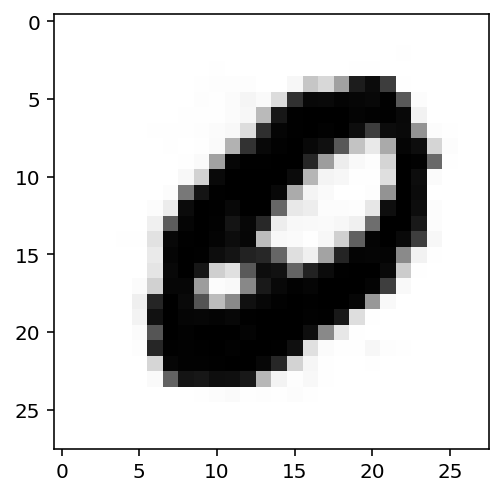

In [82]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [83]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0034879462

In [84]:
# Validate MSE
val_denoised_X = autoencoder_5.predict(validate_noisy_X)
val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.0039518876

In [85]:
# Test MSE
test_denoised_X = autoencoder_5.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.003974607

### Summary

In [86]:
pd.DataFrame(
    np.array(
        [
            ['00a', mean_squared_error(autoencoder_00a.predict(test_noisy_X), test_clean_X)],
            ['00b', mean_squared_error(autoencoder_00b.predict(test_noisy_X), test_clean_X)],
            ['1', mean_squared_error(autoencoder_1.predict(test_noisy_X), test_clean_X)],
            ['2', mean_squared_error(autoencoder_2.predict(test_noisy_X), test_clean_X)],
            ['3', mean_squared_error(autoencoder_3.predict(test_noisy_X), test_clean_X)],
            ['4', mean_squared_error(autoencoder_4.predict(test_noisy_X), test_clean_X)],
            ['5', mean_squared_error(autoencoder_5.predict(test_noisy_X), test_clean_X)],
        ]
        )
    )

,0,1
0,00a,0.003752441
1,00b,0.0034350972
2,1,0.0035004327
3,2,0.003686001
4,3,0.0036322544
5,4,0.003702869
6,5,0.003974607


In [87]:
best_hp = tuner_00b.get_best_hyperparameters()[0]

## Model 6

In [88]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model_6(hp: HyperParameters):
    
    layers = [
        # Model 00b Overcomplete Autoencoder with regularization (Sparse Autooencoder)
        Dense(
            units=best_hp.get('encoder_width'),
            activation='elu', 
            input_shape=(28 * 28,),
            activity_regularizer=regularizers.l1(hp.Float(name='regularization_rate', min_value=1e-10, max_value=1e0, sampling='log'))
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=best_hp.get('learning_rate')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [89]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner_6 = RandomSearch(
    build_model_6,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    seed = 11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_06'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner_6.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_06/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_06/tuner0.json
Search space summary
Default search space size: 1
regularization_rate (Float)
{'default': 1e-10, 'conditions': [], 'min_value': 1e-10, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [90]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)


tuner_6.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

INFO:tensorflow:Oracle triggered exit


In [91]:
# The following function can be used to view the search summary.
tuner_6.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_06
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
regularization_rate: 1.347633200421526e-09
Score: 0.004846319245795409
Trial summary
Hyperparameters:
regularization_rate: 1.170268127300911e-09
Score: 0.004854089114814997
Trial summary
Hyperparameters:
regularization_rate: 5.945903254374484e-10
Score: 0.004860791377723217
Trial summary
Hyperparameters:
regularization_rate: 6.496039145620427e-09
Score: 0.004866702947765589
Trial summary
Hyperparameters:
regularization_rate: 4.461642807129992e-09
Score: 0.0048698958319922285
Trial summary
Hyperparameters:
regularization_rate: 1.3267297692610602e-10
Score: 0.004870101033399503
Trial summary
Hyperparameters:
regularization_rate: 1.2546206903961332e-08
Score: 0.004883796131859223
Trial summary
Hyperparameters:
regularization_rate: 3.891212220299577e-08
Score: 0.004887184438606103
Trial summary
Hyperparameters:
regularization_rate: 1.9

In [92]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner_6.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,regularization_rate
trial_id,,
498089f7e2c0f1d657e1b1fdb3e21455,0.004846,1.347633e-09
72ba49f9d9dad08f94b062d689dc422f,0.004854,1.170268e-09
a45d244f38c30ff934e71a87804fe6ff,0.004861,5.945903e-10
dd3dde7b1488ab1e2bdc18eabda04072,0.004867,6.496039e-09
1a37807ac9eae79e31c53294b43be375,0.004870,4.461643e-09
5ccfc32f2b0858bf7c33588643cca0b8,0.004870,1.326730e-10
91d854ed66acaa9d5b6cda3d09878b90,0.004884,1.254621e-08
c7b257c1e96b6c84cbdba4cc62dcbe5a,0.004887,3.891212e-08
53035841df40881ff012f8dc3fa7c771,0.005009,1.936445e-07


In [93]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner_6.get_best_hyperparameters()[0]

np.random.seed(11)
tf.random.set_seed(11)
autoencoder_6 = build_model_6(best_hyperparameters)
history = train_model(autoencoder_6, epochs=200)

Epoch 1/200
383/383 [==============================] - 8s 20ms/step - loss: 0.0283 - val_loss: 0.0106
Epoch 2/200
383/383 [==============================] - 7s 19ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 3/200
383/383 [==============================] - 8s 21ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 4/200
383/383 [==============================] - 7s 18ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/200
383/383 [==============================] - 7s 19ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/200
383/383 [==============================] - 7s 19ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/200
383/383 [==============================] - 7s 18ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/200
383/383 [==============================] - 7s 18ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/200
383/383 [==============================] - 7s 18ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 10/200
383/383 [==============================] - 7s 18ms/step - loss: 0.003

In [94]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder_6.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

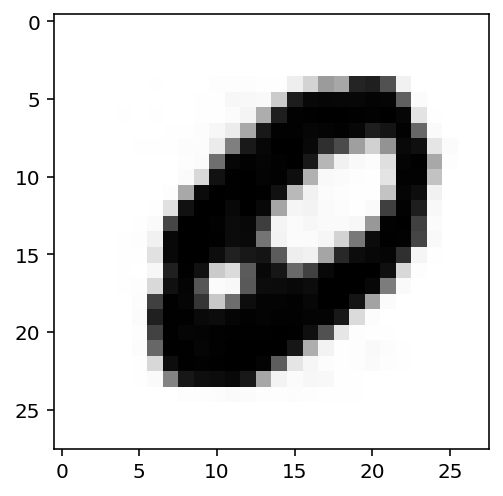

In [95]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [96]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.003078372

In [97]:
# Validate MSE
val_denoised_X = autoencoder_6.predict(validate_noisy_X)

val_denoised_X = pd.DataFrame(val_denoised_X)
mean_squared_error(val_denoised_X, validate_clean_X)

0.0034147073

In [98]:
# Test MSE
test_denoised_X = autoencoder_6.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.0034349202

In [99]:
pd.DataFrame(
    np.array(
        [
            ['00a', mean_squared_error(autoencoder_00a.predict(test_noisy_X), test_clean_X)],
            ['00b', mean_squared_error(autoencoder_00b.predict(test_noisy_X), test_clean_X)],
            ['1', mean_squared_error(autoencoder_1.predict(test_noisy_X), test_clean_X)],
            ['2', mean_squared_error(autoencoder_2.predict(test_noisy_X), test_clean_X)],
            ['3', mean_squared_error(autoencoder_3.predict(test_noisy_X), test_clean_X)],
            ['4', mean_squared_error(autoencoder_4.predict(test_noisy_X), test_clean_X)],
            ['5', mean_squared_error(autoencoder_5.predict(test_noisy_X), test_clean_X)],
            ['6', mean_squared_error(autoencoder_6.predict(test_noisy_X), test_clean_X)]
        ]
        )
    )

,0,1
0,00a,0.003752441
1,00b,0.0034350972
2,1,0.0035004327
3,2,0.003686001
4,3,0.0036322544
5,4,0.003702869
6,5,0.003974607
7,6,0.0034349202


### KFold final check

In [100]:
full_noisy = pd.concat([train_noisy_X, validate_noisy_X, test_noisy_X], axis=0)
full_clean = pd.concat([train_clean_X, validate_clean_X, test_clean_X], axis=0)

In [101]:
def train_model_kfold(model, epochs, x_train, y_train, x_val, y_val):
    history = model.fit(
        x=x_train, 
        y=y_train, 

        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(x_val, y_val),
        callbacks=[es]
    )
    return history

In [102]:
from sklearn.model_selection import KFold, train_test_split
noisy_train, noisy_test, clean_train, clean_test = train_test_split(full_noisy, full_clean, test_size=0.2, shuffle=True, random_state=11)

kf = KFold(n_splits=4, shuffle=True, random_state=11)
kf.get_n_splits(noisy_train)
out = []
for train_index, validate_index in kf.split(noisy_train):
    autoencoder_kfold = build_model_6(best_hyperparameters)
    history = train_model_kfold(autoencoder_kfold, 200, noisy_train.iloc[train_index], clean_train.iloc[train_index], noisy_train.iloc[validate_index], clean_train.iloc[validate_index])
    test_denoised_kfold = autoencoder_kfold.predict(noisy_test)
    test_denoised_kfold = pd.DataFrame(test_denoised_kfold)
    out.append(mean_squared_error(test_denoised_kfold, clean_test))
out

Epoch 1/200
296/296 [==============================] - 7s 24ms/step - loss: 0.0331 - val_loss: 0.0132
Epoch 2/200
296/296 [==============================] - 6s 21ms/step - loss: 0.0096 - val_loss: 0.0074
Epoch 3/200
296/296 [==============================] - 7s 23ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 4/200
296/296 [==============================] - 7s 23ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 5/200
296/296 [==============================] - 7s 25ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 6/200
296/296 [==============================] - 8s 26ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 7/200
296/296 [==============================] - 7s 24ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/200
296/296 [==============================] - 7s 24ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 9/200
296/296 [==============================] - 9s 31ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 10/200
296/296 [==============================] - 8s 28ms/step - loss: 0.003

[0.0034341193, 0.0034502463, 0.0034452411, 0.0034611467]

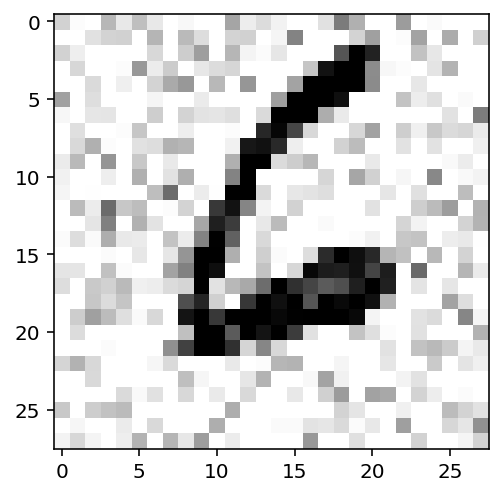

In [103]:
# Let's confirm that the denoiser works.
image_pixels = noisy_test.iloc[0]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

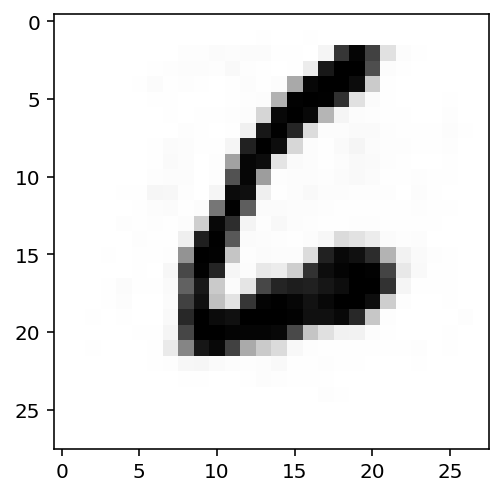

In [104]:
# Let's confirm that the denoiser works.
image_pixels = test_denoised_kfold.iloc[0]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

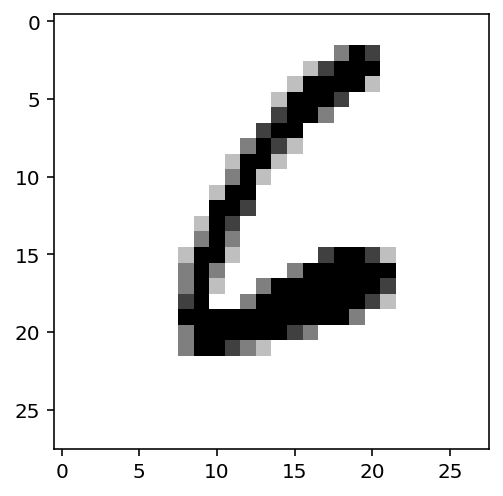

In [105]:
# Let's confirm that the denoiser works.
image_pixels = clean_test.iloc[0]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

## Assignment Output

In [106]:
autoencoder = autoencoder_6

In [107]:
import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_x.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset